# 01 - Read TEC Data

Notebook para cargar los datos usando las funciones de `data_utils.py` y mostrar algunas estadisticas

In [9]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from pathlib import Path 
import logging

import data_utils

# Set logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

## Load 2017 and 2000 Data

In [10]:
from data_utils import load_tec_data

# Load Data
datafolder = Path("tucu")
df_2017 = load_tec_data(2017, datafolder)
df_2000 = load_tec_data(2000, datafolder)

Tamaño de la serie: 864000
Porcentaje de NaNs: 8.727%
75405 NaNs y 788595 Valores no nulos.


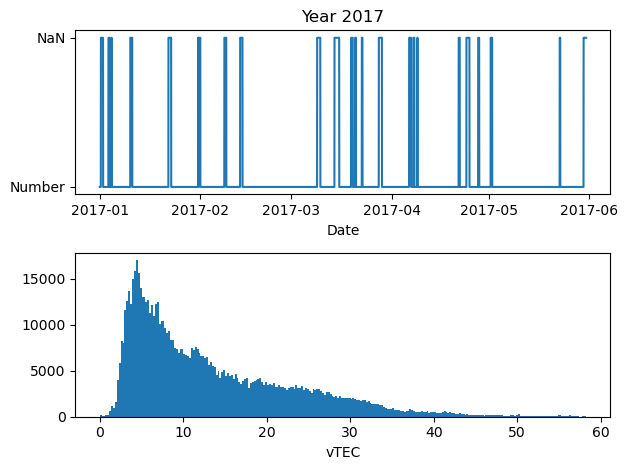

In [11]:
from data_utils import basic_stats

axs = basic_stats(df_2017.tec)
axs[0].set(xlabel="Date", title=f"Year {2017}")
axs[1].set(xlabel="vTEC")
plt.tight_layout()

Tamaño de la serie: 1054080
Porcentaje de NaNs: 0.703%
7412 NaNs y 1046668 Valores no nulos.


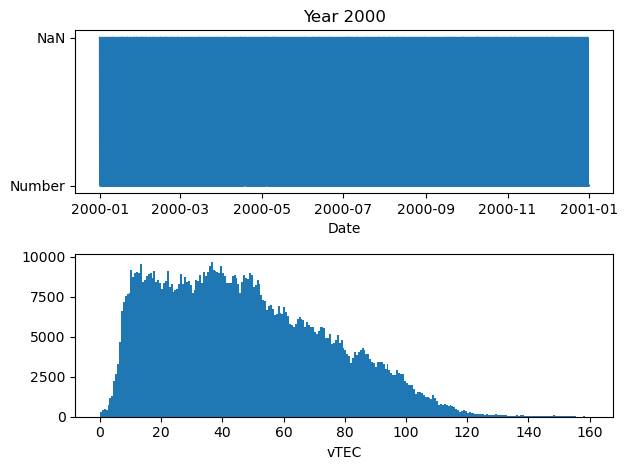

In [12]:
from data_utils import basic_stats

axs = basic_stats(df_2000.tec)
axs[0].set(xlabel="Date", title=f"Year {2000}")
axs[1].set(xlabel="vTEC")
plt.tight_layout()

## Continue with Year 2000

In [13]:
df = df_2000
year = 2000

Text(0, 0.5, 'TEC')

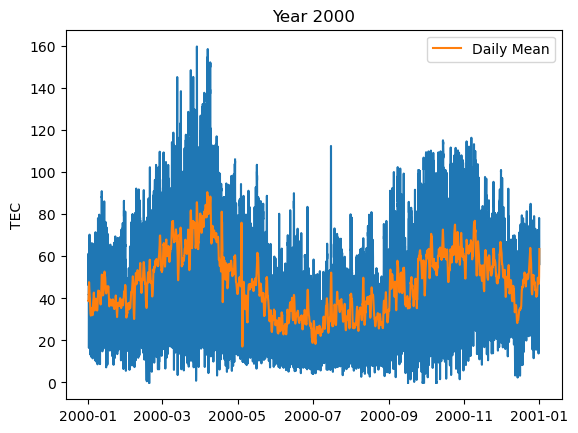

In [14]:
import matplotlib.pyplot as plt 
from datetime import timedelta

plt.plot(df_2000.tec)
plt.plot(df_2000.tec.rolling(window=timedelta(days=1), center=True).mean(), label="Daily Mean")
plt.legend()
plt.title("Year 2000")
plt.ylabel("TEC")

## Resample & Interpolate Data

Resample

Tamaño de la serie: 527040
Porcentaje de NaNs: 0.611%
3221 NaNs y 523819 Valores no nulos.


array([<Axes: >, <Axes: >], dtype=object)

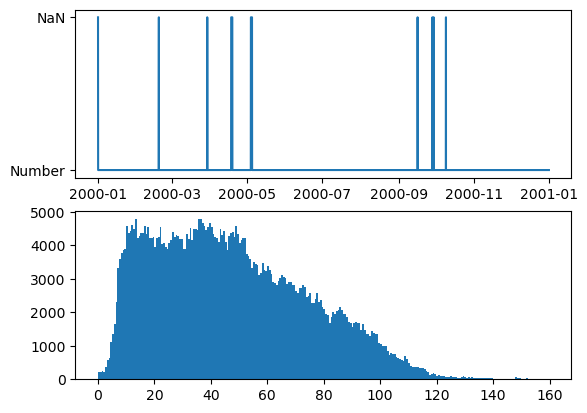

In [15]:
from datetime import timedelta

tec = df.resample(rule=timedelta(0,60)).asfreq() # resample to 60s
tec = tec.interpolate(method="linear", limit=10) # interpolate missing values with gaps shorter than 10 minutes

data_utils.basic_stats(tec.tec)

## No-gap Selection

Tamaño de la serie: 191520
Porcentaje de NaNs: 0.000%
0 NaNs y 191520 Valores no nulos.


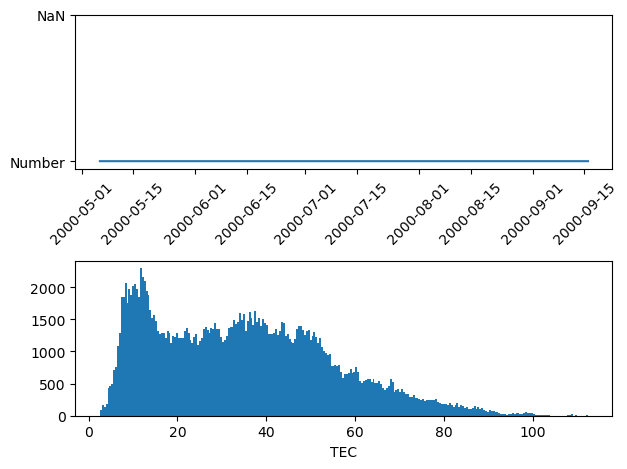

In [28]:
start_date = f"{year}-05-06"
end_date = f"{year}-09-15"
tec_selection = tec.loc[start_date:end_date]
axs = data_utils.basic_stats(tec_selection.tec)
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(),rotation=45)
axs[1].set_xlabel("TEC")
plt.tight_layout()

# 02 - Load SYM-H

In [7]:
symh = data_utils.load_symh_wdc(f"sym/ASY-SYM-WDCformat-{year}.dat")

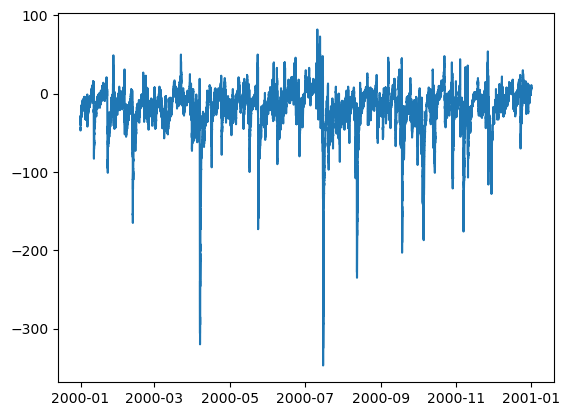

In [8]:
plt.plot(symh.symh)

# 03 - Merge TEC & SYM-H

<Axes: xlabel='datetime'>

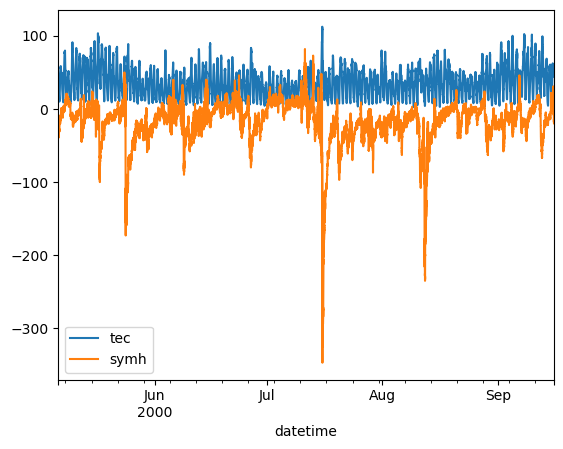

In [41]:
df = pd.merge(left=tec_selection, 
         right=symh, 
         #left_on=tec_selection.index,
         right_on=symh.index, 
         how="left",left_index=True).loc[:,["tec", "symh"]]

df.plot()

In [44]:
save = False # change to True to save df
if save:
    df.to_csv(f"tec-symh-{start_date}-{end_date}.csv")

# OLD STUFF

In [9]:
def print_gaps_lengths(series):
    """Print lengths of gaps of nans longer than 1
    """
    lengths = "".join(np.array(series.isna()).astype(int).astype("str")).split("0")
    for l in lengths:
        if not l:
            continue 
        if (w:=len(l)) > 1:
            print(w)

print_gaps_lengths(tec.tec)

137
34
1440
1440
11
12
46
104
58
28
